# Import Libraries

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
import math

# Extract Bounding Boxes from Ground Truth

In [6]:
frames = os.listdir('data/images')
labels = os.listdir('data/labels')

In [62]:
for i in range(len(frames)):
    
    ID = frames[i][0:6]     #extract frame ID
    img = frames[i]
    box = labels[i]         #extract ground truth label
    image = cv2.imread(f'data/images/{img}')     #read image
    
# org 
    org = (50, 50) 
  
# fontScale 
    fontScale = 0.4
   
# Blue color in BGR 
    color = (0, 255, 0) 
  s
# Line thickness of 2 px 
    thickness = 1
   
# Using cv2.putText() method 
     
    
    with open(f'data/labels/{box}') as f:
        data = f.readlines() 
        
    for i in data:
        x1, y1, x2, y2 = i.split()[1:5] #create a list containing the line content split into individual parts
        distance = i.split()[5]         #extract the ground truth distance
        distance = round(float(distance),2)  #convert the string to float
        x1,y1,x2,y2 = int(float(x1)), int(float(y1)), int(float(x2)), int(float(y2))  #extract bounding box coordinates
        image = cv2.rectangle(image,(x1,y1),(x2,y2),(0,255,0),1)      #draw the bounding box
        cv2.imwrite(f'Ground Truth/{ID}.png',image)                   #save the image


# Testing algorithm on a single frame


0: 224x640 1 car, 658.2ms
Speed: 2.0ms preprocess, 658.2ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
Estimated depth = 47.34500208741917 meters


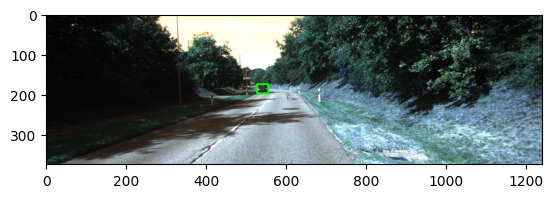

In [11]:
image = cv2.imread('data/images/006206.png')
model = YOLO('yolov8x.pt')  #choose the v8x configuration
box = model.predict(image, classes = [2], conf = 0.4)  #deploy the model on frame with 40% confidence threshold
boxes = box[0].boxes.xyxy.tolist()    #create list of bounding boxes

for i in boxes :
    x1,y1,x2,y2 = int(i[0]), int(i[1]), int(i[2]), int(i[3])
    image = cv2.rectangle(image,(x1, y1),(x2, y2),(0,255,0),3) #draw bounding boxes
    
f = open("data/calib/006206.txt", "r")
matrix_data = f.read()
new_list = [float(x) for x in matrix_data.split() ]
calib_matrix = np.array(new_list).reshape(3,3)       #create array of intrinsic camera matrix K
image_height = y2 - calib_matrix[1][2]
focal_length = calib_matrix[0][0]
camera_height = 1.65
distance = (camera_height * focal_length) / (image_height)
print(f'Estimated depth = {distance} meters')
plt.imshow(image);


0: 224x640 1 car, 747.0ms
Speed: 3.0ms preprocess, 747.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
tensor([0.5574])


47.34500208741917

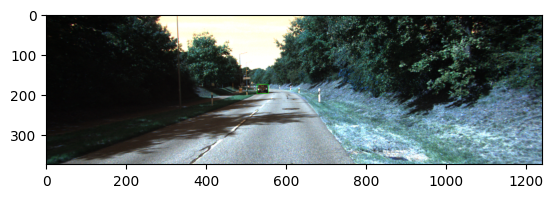

In [38]:
image = cv2.imread('data/images/006206.png')
model = YOLO('yolov8x.pt')  #choose the v8x configuration
box = model.predict(image, classes = [2], conf = 0.4)  #deploy the model on frame with 40% confidence threshold
boxes = box[0].boxes.xyxy.tolist()    #create list of bounding boxes

for i in boxes :
    x1,y1,x2,y2 = int(i[0]), int(i[1]), int(i[2]), int(i[3])
    image = cv2.rectangle(image,(x1, y1),(x2, y2),(0,255,0),1) #draw bounding boxes
    
f = open("data/calib/006206.txt", "r")
matrix_data = f.read()
new_list = [float(x) for x in matrix_data.split() ]
calib_matrix = np.array(new_list).reshape(3,3)       #create array of intrinsic camera matrix K
image_height = y2 - calib_matrix[1][2]
focal_length = calib_matrix[0][0]
camera_height = 1.65
distance = (camera_height * focal_length) / (image_height)

distance
#cv2.imwrite('sample.png',image)

# Implement Algorithm in a loop

In [74]:
frames = os.listdir('data/images')   #store all images
matrixes = os.listdir('data/calib')  #store all matrices
labels = os.listdir('data/labels')   #store all ground truth labels

estimated_distances = []  #this list contains all estimated distances to cars on all frames
true_distances = []       #this list contains all ground truth distances to cars on all frames


for i in range(len(frames)):

    bb_gt = []               #this list contains all groud truth bounding boxes on the chosen frame
    bb_pred = []             #this list contains all YOLO bounding boxes on the chosen frame
    bb_pred_filtered = []    #this list contains all filtered YOLO bounding boxes on the chosen frame
    bb_gt_filtered = []      #this list contains all filtered groud truth bounding boxes on the chosen frame
    
    ID = frames[i][0:6]
    image = frames[i]         #extract image
    matrix = matrixes[i]      #extract intrinsic matrix
    ground_truth = labels[i]  #extract ground truth label

    true_distances_frame = []       #this list contains all ground truth distances to cars on the chosen frame
    estimated_distances_frame = []  #this list contains all estimated distances to cars on the chosen frame

    with open(f'data/labels/{ground_truth}') as f:
        data = f.readlines()
        
    for j in data:
        x1, y1, x2, y2 = j.split()[1:5]
        distance = j.split()[5]
        distance = round(float(distance),2)
        x1,y1,x2,y2 = int(float(x1)), int(float(y1)), int(float(x2)), int(float(y2))
        box = [x1,y1,x2,y2,distance]
        bb_gt.append(box)
    
    
    model = YOLO('yolov8x.pt')
    image = cv2.imread(f'data/images/{image}')
    f = open(f"data/calib/{matrix}", "r")
    matrix_data = f.read()
    new_list = [float(x) for x in matrix_data.split() ]
    calib_matrix = np.array(new_list).reshape(3,3)
    
    box = model.predict(image, classes = [2], conf = 0.4)   #deploy YOLO model
    boxes = box[0].boxes.xyxy.tolist()
    
    for i in boxes :
        x1,y1,x2,y2 = int(i[0]), int(i[1]), int(i[2]), int(i[3])
        box = [x1,y1,x2,y2]
        bb_pred.append(box)

    #apply filtering algorithm to remove bounding boxes around cars which are not included in the ground truth
    for i in bb_pred:
        for x in range(len(bb_gt)):
            iou = calculate_iou(i,bb_gt[x][:4])
            if iou < 0.5 :
                pass
            else :
                bb_pred_filtered.append(i)
                bb_gt_filtered.append(bb_gt[x])
    
    bb_gt_filtered, bb_pred_filtered = sorted(bb_gt_filtered), sorted(bb_pred_filtered) #sort the boxes in the same order
    for i in bb_gt_filtered :
        true_distances_frame.append(i[4])

    font = cv2.FONT_HERSHEY_SIMPLEX 

# # org 
    org = (50, 50) 
  
# # fontScale 
    fontScale = 0.5
   
# # Blue color in BGR 
    color = (0, 255, 0) 
  
# # Line thickness of 2 px 
    thickness = 1

    text_color_bg=(0, 0, 0)

    #extract the coordinates of ground truth and predicted bounding boxes
    for i in range(len(bb_pred_filtered)):
        x1, y1, x2, y2 = bb_pred_filtered[i][0], bb_pred_filtered[i][1], bb_pred_filtered[i][2], bb_pred_filtered[i][3]
        x1g, y1g, x2g, y2g = bb_gt_filtered[i][0], bb_gt_filtered[i][1], bb_gt_filtered[i][2], bb_gt_filtered[i][3]

    # Apply distance estimation algorithm on filtered predicted bounding boxes        
        x_in_image = abs(((x1+x2)/2) - calib_matrix[0][2])
        image_height = abs(y2 - calib_matrix[1][2])
        focal_length = calib_matrix[0][0]
        image_distance = math.sqrt(x_in_image**2 + focal_length**2)
        camera_height = 1.65
        distance = (camera_height * image_distance) / (image_height)        #estimate depth to the detected car depth
        estimated_distances_frame.append(round(distance,2))                 #store estimated distance to that detected car
        gt_distance = bb_gt_filtered[i][4]                                  
        image = cv2.rectangle(image,(x1g, y1g),(x2g, y2g),(0,255,0),1)      #draw green bounding box for ground truth
        image = cv2.rectangle(image,(x1, y1),(x2, y2),(0,0,255),1)          #draw red bounding box for prediction
        
   # Write the ground truth and predicted depth above the bounding boxes inside a white rectangle for better visibility     
        string = f'YOLO - {str(round(distance,2))}\nGT - {str(gt_distance)}' #create the text containing the depths

        cv2.rectangle(image, (x1g, y1g -35), (x1g+120,y1g), (255, 255, 255), -1)  #draw white rectangle
        lines = string.split('\n')
        
        for i, line in enumerate(lines):
            
            image = cv2.putText(image, line , (x1g, y1g - 5 -(i * 15)), font, fontScale, (0,0,0), thickness, cv2.LINE_AA)
        
    true_distances.append(true_distances_frame)      #store all ground truth depths of cars on the frame in a master list
    estimated_distances.append(estimated_distances_frame) #store all predicted depths of cars on the frame in a master list
    cv2.imwrite(f'Results/Report/{ID}.png',image)       #save the image with both depths written on it above the boxes


0: 224x640 5 cars, 925.5ms
Speed: 2.0ms preprocess, 925.5ms inference, 3.0ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 3 cars, 1382.3ms
Speed: 9.0ms preprocess, 1382.3ms inference, 3.0ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 7 cars, 905.6ms
Speed: 3.0ms preprocess, 905.6ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 10 cars, 925.5ms
Speed: 2.0ms preprocess, 925.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 6 cars, 1028.3ms
Speed: 2.0ms preprocess, 1028.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 6 cars, 926.5ms
Speed: 2.0ms preprocess, 926.5ms inference, 3.0ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 9 cars, 1073.1ms
Speed: 3.0ms preprocess, 1073.1ms inference, 3.0ms postprocess per image at shape (1, 3, 224, 640)

0: 224x640 4 cars, 957.4ms
Speed: 3.0ms preprocess, 957.4ms inference, 2.0ms postprocess per image at shape (1

# Function to calculate IOU

In [7]:
def calculate_iou(box1, box2):
    # Unpack the coordinates of the bounding boxes
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Calculate the coordinates of the intersection rectangle
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    # Calculate the area of the intersection rectangle
    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    inter_area = inter_width * inter_height

    # Calculate the area of both bounding boxes
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # Calculate the area of the union
    union_area = box1_area + box2_area - inter_area

    # Calculate the Intersection over Union
    iou = inter_area / union_area

    return iou


# Plot the predicted and actual depths

In [77]:
all_true_distances = []
for i in true_distances:
    for j in i :
        all_true_distances.append(j)

In [78]:
all_estimated_distances = []
for i in estimated_distances:
    for j in i :
        all_estimated_distances.append(j)

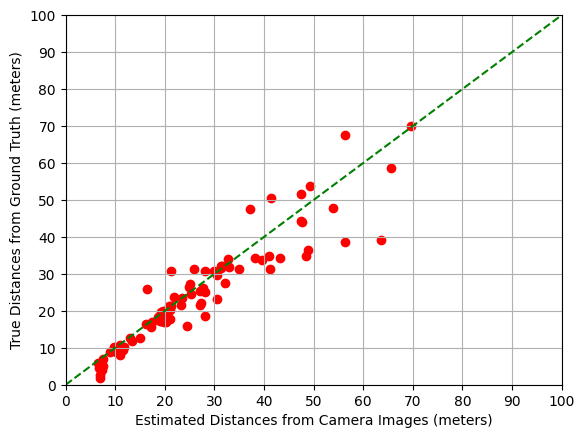

In [80]:
#plt.figure(figsize=(8,8))
plt.scatter(all_estimated_distances, all_true_distances,c = 'r')
plt.xlabel('Estimated Distances from Camera Images (meters)')
plt.ylabel('True Distances from Ground Truth (meters)')
plt.grid()
x = [0, 100]
y = [0, 100]
# Plot the line
plt.plot(x, y, label='45-degree line',linestyle = '--',c = 'g')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xticks([i for i in range(0,101,10)]);  # Adjust x-axis tick frequency
plt.yticks([i for i in range(0,101,10)]); 
plt.savefig('Plot.png')